# Extract Allstate auto table

Author: Mo Al Elew

**What notebook does/produces:**

Extracts territory rate setting tables from Auto Club filing PDFs and produces data files for analysis

**Issue/problem being solved:**

- Table is stored in a PDF

**Strategy to solve:**

General pattern:

1. Extract table data from PDF
2. Clean and process the data into a standardized format
3. Run any necessary caclulations to produce location effect figure
4. Match on geographic and demographic data
5. Determine nearest neighbor with lowest base rate

**Sources:**

- data.census.gov
- https://www2.census.gov/geo/tiger/TIGER2020/
- System for Electronic Rates and Forms Filing (SERFF)


In [1]:
import re
import zipfile
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
import stringcase
import tabula
from sklearn.neighbors import NearestNeighbors

# Constants

In [2]:
PDF_ZIP_FP = "./inputs/19-mi-ppa-afcic-r55731-rate-table_1-allstate-auto.zip"
PDF_FILE_NAME = "19-mi-ppa-afcic-r55731-rate-table_1-allstate-auto.pdf"
ZCTA_GIS_FP = "../01_demographics/outputs/zcta_demographics_map.geojson"

UNPROCESSED_EXPORT_FP = "./outputs/auto_rate_table.csv"
EXPORT_FP = "./outputs/allstate_auto.csv"
MAP_EXPORT_FP = "./outputs/allstate_auto_gis.geojson"
CLEAN_MAP_EXPORT_FP = "./outputs/allstate_auto_clean.geojson"
CLEAN_EXPORT_FP = "./outputs/allstate_auto_clean.csv"

MUNICIPAL_BOUND_GIS_FP = "./inputs/Municipal_Boundaries.zip"

In [3]:
DETROIT_STREETS = (
    "./inputs/City_of_Detroit_Act51_Map_view_only_588694915804796340.geojson"
)
STREET_EXPORT_FP = "./outputs/eight_mile.geojson"

ROADS_TO_FILTER = ["8 Mile Rd"]
EIGHT_MILE_RD_BOUND_LAT = 42.45
MILE_BUFFER = 3200  # meters

PROJECTED_CRS = "EPSG:3078"
EXAMPLE_COORD = "N4326750W08627250"

In [4]:
COLUMN_NAMES = [
    "LOCATION ZONE",
    "Bodily Injury",
    "Property Damage",
    "PIP",
    "NON MED",
    "Collision",
    "Comprehensive",
    "UM - Single Car",
    "UM - Multi Car",
    "UIM - Single Car",
    "UIM - Multi Car",
]

BASE_COLUMNS = [
    "company",
    "vehicle_type",
    "factor_circumvented",
    "factor_name",
    "geography_factor",
    "geography_type",
    "geography_factor_id",
    "latitude",
    "longitude",
    "county_fips",
    "tract_fips",
    "block_group_fips",
    "zip",
    "place_name_fips",
]

ZCTA_COLUMNS_TO_MERGE = [
    "geoid20",
    "geo_id",
    "geo_name",
    "total_pop",
    "latin_pct",
    "white_pct",
    "black_pct",
    "aian_pct",
    "asian_pct",
    "nhpi_pct",
    "other_pct",
    "two_plus_pct",
    "white_tot",
    "black_tot",
    "median_income",
    "density",
    "geometry",
]

PCT_COL = [
    "latin_pct",
    "white_pct",
    "black_pct",
    "aian_pct",
    "asian_pct",
    "nhpi_pct",
    "other_pct",
    "two_plus_pct",
]

CLEAN_EXPORT_COLS = [
    "geo_id",
    "geo_name",
    "latitude",
    "longitude",
    "total_pop",
    "white_pct",
    "black_pct",
    "white_tot",
    "black_tot",
    "median_income",
    "generic_location_based_premium",
    "location_effect",
    "density",
    "is_in_detroit",
    "loc_rate_div_min_nn",
    "nn_min_val",
    "is_zcta_border",
    "is_south_8_mile",
    "is_north_8_mile",
]

RATE_COMPONENT_COLS = [
    "rate_um_single_car",
    "rate_um_multi_car",
    "rate_uim_single_car",
    "rate_uim_multi_car",
    "rate_non_med",
]

In [5]:
PAGE_COUNT = 1015
BATCH_STEP = 100
HEADER_N = 2

COMPANY_NAME = "Allstate"
VEHICLE_TYPE = "Auto"
FACTOR_CIRCUMVENTED = "zip"
FACTOR_NAME = "Territorial Base Rate"
GEOGRAPHY_FACTOR = "location_zones"
GEOGRAPHY_TYPE = "coordinate"

MUNICIPALITIES_TO_EXTRACT = ["Detroit"]

RATE_PREFIX = "rate_"

In [6]:
def get_rate_columns(df_rate_table):
    return [col for col in df_rate_table.columns if col.startswith(RATE_PREFIX)]

# Read data

## Location zones

Read in from PDF

In [7]:
def drop_header_row(df, n=1):
    return df.iloc[n:].copy()


def read_table(page_list):
    col2str = {"dtype": str}
    kwargs = {"pandas_options": col2str}
    with zipfile.ZipFile(PDF_ZIP_FP) as z:
        with z.open(PDF_FILE_NAME) as f:
            tables = tabula.read_pdf(f, pages=page_list, stream=True, **kwargs)
    return pd.concat([drop_header_row(table, HEADER_N) for table in tables])

In [8]:
if Path(UNPROCESSED_EXPORT_FP).is_file():
    DF_LOC_ZONES = pd.read_csv(UNPROCESSED_EXPORT_FP)

else:
    tables = []
    page_steps = list(range(1, PAGE_COUNT, BATCH_STEP)) + [PAGE_COUNT]
    for idx, page in enumerate(page_steps):
        if idx + 1 < len(page_steps):
            pages = list(range(page, page_steps[idx + 1]))
            tables.append(read_table(pages))

    DF_LOC_ZONES = pd.concat(tables)
    DF_LOC_ZONES = DF_LOC_ZONES.dropna(how="all", axis=1)
    DF_LOC_ZONES = DF_LOC_ZONES.reset_index(drop=True)
    DF_LOC_ZONES.columns = COLUMN_NAMES

    is_expected_prefix = DF_LOC_ZONES["LOCATION ZONE"].str.startswith("N", na=False)
    DF_LOC_ZONES = DF_LOC_ZONES[is_expected_prefix].copy()

    DF_LOC_ZONES.to_csv(UNPROCESSED_EXPORT_FP, index=False)


DF_LOC_ZONES

,LOCATION ZONE,Bodily Injury,Property Damage,PIP,NON MED,Collision,Comprehensive,UM - Single Car,UM - Multi Car,UIM - Single Car,UIM - Multi Car
0,N4822552W08836531,287.00,52.61,"2,531.59",261.98,283.17,20.40,19.68,19.68,26.19,26.19
1,N4823109W08835580,287.00,52.61,"2,531.59",261.98,283.17,20.40,19.68,19.68,26.19,26.19
2,N4823530W08834466,287.00,52.61,"2,531.59",261.98,283.17,20.40,19.68,19.68,26.19,26.19
3,N4822421W08836573,287.00,52.61,"2,531.59",261.98,283.17,20.40,19.68,19.68,26.19,26.19
4,N4822450W08836423,287.00,52.61,"2,531.59",261.98,283.17,20.40,19.68,19.68,26.19,26.19
...,...,...,...,...,...,...,...,...,...,...,...
78010,N4169917W08472783,334.11,56.56,"2,628.21",271.98,312.54,51.51,19.68,19.68,26.19,26.19
78011,N4169938W08471294,334.11,56.56,"2,628.21",271.98,312.54,51.51,19.68,19.68,26.19,26.19
78012,N4169960W08469819,334.11,56.56,"2,628.21",271.98,312.54,51.51,19.68,19.68,26.19,26.19
78013,N4169980W08468402,334.11,56.56,"2,628.21",271.98,312.54,51.51,19.68,19.68,26.19,26.19


## ZCTA demographics

In [9]:
GDF_ZCTA = gpd.read_file(ZCTA_GIS_FP)

## Municipal boundaries


In [10]:
GDF_MUNICIPAL = gpd.read_file(MUNICIPAL_BOUND_GIS_FP)
gdf_detroit = GDF_MUNICIPAL[GDF_MUNICIPAL["NAME"].isin(MUNICIPALITIES_TO_EXTRACT)]

# Build processed table

In [11]:
df_processed_table = DF_LOC_ZONES.copy()
df_processed_table

,LOCATION ZONE,Bodily Injury,Property Damage,PIP,NON MED,Collision,Comprehensive,UM - Single Car,UM - Multi Car,UIM - Single Car,UIM - Multi Car
0,N4822552W08836531,287.00,52.61,"2,531.59",261.98,283.17,20.40,19.68,19.68,26.19,26.19
1,N4823109W08835580,287.00,52.61,"2,531.59",261.98,283.17,20.40,19.68,19.68,26.19,26.19
2,N4823530W08834466,287.00,52.61,"2,531.59",261.98,283.17,20.40,19.68,19.68,26.19,26.19
3,N4822421W08836573,287.00,52.61,"2,531.59",261.98,283.17,20.40,19.68,19.68,26.19,26.19
4,N4822450W08836423,287.00,52.61,"2,531.59",261.98,283.17,20.40,19.68,19.68,26.19,26.19
...,...,...,...,...,...,...,...,...,...,...,...
78010,N4169917W08472783,334.11,56.56,"2,628.21",271.98,312.54,51.51,19.68,19.68,26.19,26.19
78011,N4169938W08471294,334.11,56.56,"2,628.21",271.98,312.54,51.51,19.68,19.68,26.19,26.19
78012,N4169960W08469819,334.11,56.56,"2,628.21",271.98,312.54,51.51,19.68,19.68,26.19,26.19
78013,N4169980W08468402,334.11,56.56,"2,628.21",271.98,312.54,51.51,19.68,19.68,26.19,26.19


## Rename rate columns

In [12]:
def create_rate_label(col_name):
    return RATE_PREFIX + stringcase.snakecase(col_name.lower()).replace("___", "_")


rate_col_names = df_processed_table.columns[1:]
extracted_rate_col_names = [create_rate_label(col_name) for col_name in rate_col_names]
rate_col_renames = dict(zip(rate_col_names, extracted_rate_col_names))
df_processed_table = df_processed_table.rename(columns=rate_col_renames)
df_processed_table

,LOCATION ZONE,rate_bodily_injury,rate_property_damage,rate_pip,rate_non_med,rate_collision,rate_comprehensive,rate_um_single_car,rate_um_multi_car,rate_uim_single_car,rate_uim_multi_car
0,N4822552W08836531,287.00,52.61,"2,531.59",261.98,283.17,20.40,19.68,19.68,26.19,26.19
1,N4823109W08835580,287.00,52.61,"2,531.59",261.98,283.17,20.40,19.68,19.68,26.19,26.19
2,N4823530W08834466,287.00,52.61,"2,531.59",261.98,283.17,20.40,19.68,19.68,26.19,26.19
3,N4822421W08836573,287.00,52.61,"2,531.59",261.98,283.17,20.40,19.68,19.68,26.19,26.19
4,N4822450W08836423,287.00,52.61,"2,531.59",261.98,283.17,20.40,19.68,19.68,26.19,26.19
...,...,...,...,...,...,...,...,...,...,...,...
78010,N4169917W08472783,334.11,56.56,"2,628.21",271.98,312.54,51.51,19.68,19.68,26.19,26.19
78011,N4169938W08471294,334.11,56.56,"2,628.21",271.98,312.54,51.51,19.68,19.68,26.19,26.19
78012,N4169960W08469819,334.11,56.56,"2,628.21",271.98,312.54,51.51,19.68,19.68,26.19,26.19
78013,N4169980W08468402,334.11,56.56,"2,628.21",271.98,312.54,51.51,19.68,19.68,26.19,26.19


In [13]:
df_processed_table[extracted_rate_col_names] = (
    df_processed_table[extracted_rate_col_names]
    .replace(",", "", regex=True)
    .astype(float)
)

## Aggregate base rates

**uninsured and underinsured motorist coverage**

First, I assert the equality of single car and multi-car coverage for uninsured and underinsured motorist coverage. Passing this verification check supports that the distinction between the categories has to do with the number of cars and not the rate assessed. The coverages are likely mutually exclusive hence we can just sum either single car or multicar to get the base rate for purchasing both.

In [14]:
# uninsured and underisnured
assert df_processed_table["rate_uim_multi_car"].equals(
    df_processed_table["rate_uim_single_car"]
)
assert df_processed_table["rate_um_multi_car"].equals(
    df_processed_table["rate_um_single_car"]
)

df_processed_table["rate_um_uim"] = (
    df_processed_table["rate_uim_single_car"] + df_processed_table["rate_um_single_car"]
)

In [15]:
df_processed_table["rate_pip"] = (
    DF_LOC_ZONES["PIP"].str.replace(",", "").astype(float).copy()
)

df_processed_table["rate_pip"] = (
    df_processed_table["rate_pip"] + df_processed_table["rate_non_med"]
)

In [16]:
# drop component columns
df_processed_table = df_processed_table.drop(
    RATE_COMPONENT_COLS,
    axis=1,
)

In [17]:
extracted_rate_col_names = get_rate_columns(df_processed_table)

Update from six month term to 12

In [18]:
df_processed_table["generic_location_based_premium"] = df_processed_table[
    get_rate_columns(df_processed_table)
].sum(axis=1)
df_processed_table["generic_location_based_premium"] = (
    df_processed_table["generic_location_based_premium"]
    + df_processed_table["generic_location_based_premium"]
)
df_processed_table

,LOCATION ZONE,rate_bodily_injury,rate_property_damage,rate_pip,rate_collision,rate_comprehensive,rate_um_uim,generic_location_based_premium
0,N4822552W08836531,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24
1,N4823109W08835580,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24
2,N4823530W08834466,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24
3,N4822421W08836573,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24
4,N4822450W08836423,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24
...,...,...,...,...,...,...,...,...
78010,N4169917W08472783,334.11,56.56,2900.19,312.54,51.51,45.87,7401.56
78011,N4169938W08471294,334.11,56.56,2900.19,312.54,51.51,45.87,7401.56
78012,N4169960W08469819,334.11,56.56,2900.19,312.54,51.51,45.87,7401.56
78013,N4169980W08468402,334.11,56.56,2900.19,312.54,51.51,45.87,7401.56


## Index to median

In [19]:
median_loc_base_rate = df_processed_table["generic_location_based_premium"].median()
df_processed_table["location_effect"] = round(
    df_processed_table["generic_location_based_premium"] / median_loc_base_rate, 2
)

In [20]:
extracted_rate_col_names = extracted_rate_col_names + [
    "generic_location_based_premium",
    "location_effect",
]

## Geography columns

Rename geography index column

In [21]:
df_processed_table = df_processed_table.rename(
    columns={"LOCATION ZONE": "geography_factor_id"}
)
df_processed_table

,geography_factor_id,rate_bodily_injury,rate_property_damage,rate_pip,rate_collision,rate_comprehensive,rate_um_uim,generic_location_based_premium,location_effect
0,N4822552W08836531,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24,1.00
1,N4823109W08835580,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24,1.00
2,N4823530W08834466,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24,1.00
3,N4822421W08836573,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24,1.00
4,N4822450W08836423,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24,1.00
...,...,...,...,...,...,...,...,...,...
78010,N4169917W08472783,334.11,56.56,2900.19,312.54,51.51,45.87,7401.56,1.06
78011,N4169938W08471294,334.11,56.56,2900.19,312.54,51.51,45.87,7401.56,1.06
78012,N4169960W08469819,334.11,56.56,2900.19,312.54,51.51,45.87,7401.56,1.06
78013,N4169980W08468402,334.11,56.56,2900.19,312.54,51.51,45.87,7401.56,1.06


Set geography values

In [22]:
def get_gis(loc):
    coords = re.findall(r"\d+", loc)
    coords = [float(coord) / 100000 for coord in coords]
    coords = [coords[0], -1 * coords[1]]
    return pd.Series(coords)


example_gis_output = get_gis(EXAMPLE_COORD)
print(
    f"For example, {EXAMPLE_COORD} gets output as {example_gis_output[0]}, {example_gis_output[1]}"
)

df_processed_table[["latitude", "longitude"]] = df_processed_table[
    "geography_factor_id"
].apply(get_gis)
df_processed_table

For example, N4326750W08627250 gets output as 43.2675, -86.2725


,geography_factor_id,rate_bodily_injury,rate_property_damage,rate_pip,rate_collision,rate_comprehensive,rate_um_uim,generic_location_based_premium,location_effect,latitude,longitude
0,N4822552W08836531,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24,1.00,48.22552,-88.36531
1,N4823109W08835580,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24,1.00,48.23109,-88.35580
2,N4823530W08834466,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24,1.00,48.23530,-88.34466
3,N4822421W08836573,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24,1.00,48.22421,-88.36573
4,N4822450W08836423,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24,1.00,48.22450,-88.36423
...,...,...,...,...,...,...,...,...,...,...,...
78010,N4169917W08472783,334.11,56.56,2900.19,312.54,51.51,45.87,7401.56,1.06,41.69917,-84.72783
78011,N4169938W08471294,334.11,56.56,2900.19,312.54,51.51,45.87,7401.56,1.06,41.69938,-84.71294
78012,N4169960W08469819,334.11,56.56,2900.19,312.54,51.51,45.87,7401.56,1.06,41.69960,-84.69819
78013,N4169980W08468402,334.11,56.56,2900.19,312.54,51.51,45.87,7401.56,1.06,41.69980,-84.68402


## Fill constants

In [23]:
df_processed_table["company"] = COMPANY_NAME
df_processed_table["vehicle_type"] = VEHICLE_TYPE
df_processed_table["factor_circumvented"] = FACTOR_CIRCUMVENTED
df_processed_table["factor_name"] = FACTOR_NAME
df_processed_table["geography_factor"] = GEOGRAPHY_FACTOR
df_processed_table["geography_type"] = GEOGRAPHY_TYPE

In [24]:
def fill_null_columns(df, base_columns):
    base_col_to_fill = list(set(base_columns) - set(df.columns))
    df[base_col_to_fill] = None
    return df


df_processed_table = fill_null_columns(df_processed_table, BASE_COLUMNS)

# Join geographic and demographic data with insurance tables


Calculate population density and filter for columns to merge on

In [25]:
GDF_ZCTA["density"] = GDF_ZCTA["total_pop"] / GDF_ZCTA.to_crs(PROJECTED_CRS).area
gdf_zcta = GDF_ZCTA[ZCTA_COLUMNS_TO_MERGE].copy()
gdf_zcta.head()

,geoid20,geo_id,geo_name,total_pop,latin_pct,white_pct,black_pct,aian_pct,asian_pct,nhpi_pct,other_pct,two_plus_pct,white_tot,black_tot,median_income,density,geometry
0,48756,860Z200US48756,ZCTA5 48756,3956,3.3,93.8,0.4,0.1,0.0,0.0,0.0,2.5,3711,16,39115,0.000019,"POLYGON ((-84.07938 44.20834, -84.07921 44.208..."
1,49721,860Z200US49721,ZCTA5 49721,14034,2.1,91.2,0.8,2.1,0.5,0.0,0.1,3.2,12793,113,58163,0.000018,"POLYGON ((-84.72290 45.67864, -84.72290 45.678..."
2,49648,860Z200US49648,ZCTA5 49648,2572,2.0,97.2,0.1,0.1,0.0,0.0,0.0,0.6,2500,3,85995,0.000020,"POLYGON ((-85.40704 44.95004, -85.40631 44.953..."
3,49854,860Z200US49854,ZCTA5 49854,6172,0.9,84.2,0.6,6.3,0.3,0.0,0.0,7.6,5199,39,53836,0.000005,"POLYGON ((-86.61540 46.33326, -86.60496 46.333..."
4,49783,860Z200US49783,ZCTA5 49783,18905,1.5,71.5,0.8,12.5,0.9,0.1,1.1,11.7,13517,151,57667,0.000038,"POLYGON ((-84.48931 46.43857, -84.47940 46.448..."


In [26]:
gdf_rate_table = gpd.GeoDataFrame(
    df_processed_table,
    geometry=gpd.points_from_xy(
        df_processed_table["longitude"], df_processed_table["latitude"]
    ),
)

In [27]:
gdf_rate_table_demographics_joined = gdf_rate_table.sjoin(
    GDF_ZCTA, how="left", predicate="intersects"
)
gdf_rate_table_demographics_joined

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:2195: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


,geography_factor_id,rate_bodily_injury,rate_property_damage,rate_pip,rate_collision,rate_comprehensive,rate_um_uim,generic_location_based_premium,location_effect,latitude,...,latin_tot,white_tot,black_tot,aian_tot,asian_tot,nhpi_tot,other_tot,two_plus_tot,median_income,density
0,N4822552W08836531,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24,1.00,48.22552,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N4823109W08835580,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24,1.00,48.23109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N4823530W08834466,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24,1.00,48.23530,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N4822421W08836573,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24,1.00,48.22421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N4822450W08836423,287.00,52.61,2793.57,283.17,20.40,45.87,6965.24,1.00,48.22450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78010,N4169917W08472783,334.11,56.56,2900.19,312.54,51.51,45.87,7401.56,1.06,41.69917,...,54.0,2641.0,6.0,0.0,0.0,0.0,0.0,41.0,53203,0.000017
78011,N4169938W08471294,334.11,56.56,2900.19,312.54,51.51,45.87,7401.56,1.06,41.69938,...,54.0,2641.0,6.0,0.0,0.0,0.0,0.0,41.0,53203,0.000017
78012,N4169960W08469819,334.11,56.56,2900.19,312.54,51.51,45.87,7401.56,1.06,41.69960,...,54.0,2641.0,6.0,0.0,0.0,0.0,0.0,41.0,53203,0.000017
78013,N4169980W08468402,334.11,56.56,2900.19,312.54,51.51,45.87,7401.56,1.06,41.69980,...,54.0,2641.0,6.0,0.0,0.0,0.0,0.0,41.0,53203,0.000017


Replace "-" pct values indicating zero population with 0-value

In [28]:
gdf_rate_table_demographics_joined[PCT_COL] = gdf_rate_table_demographics_joined[
    PCT_COL
].replace("-", 0)

Replace placeholder values with either the min value indicated or a -1 to indicate no valid income data

In [29]:
gdf_rate_table_demographics_joined["median_income"] = (
    gdf_rate_table_demographics_joined["median_income"].replace("2,500-", "2500")
)
gdf_rate_table_demographics_joined["median_income"] = (
    gdf_rate_table_demographics_joined["median_income"].replace("-", -1).astype(float)
)

## Detroit filter

In [30]:
gdf_rate_table_demographics_joined.set_crs(epsg=4326, inplace=True)
gdf_detroit_points = list(
    gpd.overlay(gdf_rate_table_demographics_joined, gdf_detroit.to_crs(4326))[
        "geography_factor_id"
    ]
)
gdf_rate_table_demographics_joined["is_in_detroit"] = (
    gdf_rate_table_demographics_joined["geography_factor_id"].isin(gdf_detroit_points)
)

## 8 Mile Road

In [31]:
GDF_STREETS = gpd.read_file(DETROIT_STREETS)

gdf_roads_8_mile = GDF_STREETS[GDF_STREETS["RDNAME"].isin(ROADS_TO_FILTER)].copy()
gdf_roads_8_mile_buffered = gdf_roads_8_mile.copy()
gdf_roads_8_mile_buffered["geometry"] = gdf_roads_8_mile_buffered["geometry"].buffer(
    MILE_BUFFER
)
gdf_roads_8_mile_buffered

,FID,RDNAME,Type,Shape__Len,Shape__L_1,Shape_Leng,Shape__L_2,Shape_Le_1,Shape_Le_2,geometry
0,1,8 Mile Rd,MDOT,19.172881,30855.822722,0.0,0.0,41753.78875,41753.78875,"POLYGON ((-9271637.297 5230697.376, -9271637.3..."


Filter for rates near 8 mile drive

<Axes: >

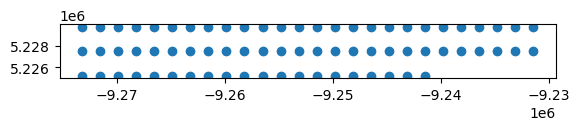

In [32]:
gdf_8_mile_rates = gpd.overlay(
    gdf_rate_table_demographics_joined.to_crs(gdf_roads_8_mile_buffered.crs),
    gdf_roads_8_mile_buffered,
)
gdf_8_mile_rates.plot()

In [33]:
gdf_rate_table_demographics_joined["is_along_8_mile"] = (
    gdf_rate_table_demographics_joined["geography_factor_id"].isin(
        gdf_8_mile_rates["geography_factor_id"]
    )
)

gdf_rate_table_demographics_joined["is_south_8_mile"] = (
    gdf_rate_table_demographics_joined["latitude"] < EIGHT_MILE_RD_BOUND_LAT
) & gdf_rate_table_demographics_joined["is_along_8_mile"]
gdf_rate_table_demographics_joined["is_north_8_mile"] = (
    ~(gdf_rate_table_demographics_joined["is_south_8_mile"])
    & gdf_rate_table_demographics_joined["is_along_8_mile"]
)

# Nearest Neighbor

In [34]:
# adapted from https://stackoverflow.com/questions/56520780/how-to-use-geopanda-or-shapely-to-find-nearest-point-in-same-geodataframe
def n_nearest_neighbors(df, n_neighbors):
    # 2d numpy array of the coordinates
    coords = np.array(df.geometry.map(lambda p: [p.x, p.y]).tolist())

    # "train"/initialize the NearestNeighbors model
    # NOTE: N_NEIGHBORS + 1 since we are dropping the nearest point
    #       (which is each point itself with distance 0)
    knn = NearestNeighbors(n_neighbors=n_neighbors + 1, algorithm="kd_tree").fit(coords)
    # retrieve neighbors (distance and index)
    knn_dist, knn_idx = knn.kneighbors(coords)

    # add results to dataframe:
    df[list(map("NEIGHBOR_{}".format, range(1, n_neighbors + 1)))] = (
        df.geometry.values.to_numpy()[knn_idx[:, 1:]]
    )
    rate_cols = list(map("NEIGHBOR_RATE_{}".format, range(1, n_neighbors + 1)))
    df[rate_cols] = df["generic_location_based_premium"].to_numpy()[knn_idx[:, 1:]]

    geo_id_cols = list(map("NEIGHBOR_GEO_ID_{}".format, range(1, n_neighbors + 1)))
    neighbor_geo_id = df["geo_id"].to_numpy()[knn_idx[:, 1:]]
    df["neighbors_geo_id"] = [set(i) for i in neighbor_geo_id]

    for idx, col in enumerate(rate_cols):
        df[f"NEIGHBOR_DIV_{idx+1}"] = df["generic_location_based_premium"] / df[col]

In [35]:
NEAREST_NEIGHBOR_COUNT = 8
gdf_nn = gdf_rate_table_demographics_joined.copy()
gdf_nn = gdf_nn.to_crs("EPSG:3857")
n_nearest_neighbors(gdf_nn, NEAREST_NEIGHBOR_COUNT)

In [36]:
div_cols = list(map("NEIGHBOR_DIV_{}".format, range(1, NEAREST_NEIGHBOR_COUNT + 1)))
nn_cols = list(map("NEIGHBOR_RATE_{}".format, range(1, NEAREST_NEIGHBOR_COUNT + 1)))

gdf_nn["loc_rate_div_min_nn"] = round(gdf_nn[div_cols].max(axis=1), 2)
gdf_nn["nn_min_val"] = gdf_nn[nn_cols].min(axis=1)
gdf_nn["is_zcta_border"] = gdf_nn["neighbors_geo_id"].apply(len) > 1

gdf_nn = gdf_nn.sort_values("loc_rate_div_min_nn", ascending=False)
gdf_nn

,geography_factor_id,rate_bodily_injury,rate_property_damage,rate_pip,rate_collision,rate_comprehensive,rate_um_uim,generic_location_based_premium,location_effect,latitude,...,NEIGHBOR_DIV_2,NEIGHBOR_DIV_3,NEIGHBOR_DIV_4,NEIGHBOR_DIV_5,NEIGHBOR_DIV_6,NEIGHBOR_DIV_7,NEIGHBOR_DIV_8,loc_rate_div_min_nn,nn_min_val,is_zcta_border
71542,N4217250W08340750,535.01,74.82,6619.74,350.44,26.54,45.87,15304.84,2.20,42.17250,...,1.388396,1.253205,1.612407,1.921690,0.990238,1.612000,1.735802,1.92,7964.26,True
72435,N4211250W08343750,529.96,74.92,6458.73,350.11,26.34,45.87,14971.86,2.15,42.11250,...,0.968694,0.968694,1.591864,0.968694,1.007536,1.882841,1.200290,1.88,7951.74,True
72211,N4212750W08340750,536.51,74.85,6694.50,349.38,26.75,45.87,15455.72,2.22,42.12750,...,1.239080,1.000000,1.086773,1.000000,1.000000,1.843166,1.000000,1.84,8385.42,True
67091,N4247250W08322750,669.04,82.76,6575.91,521.59,46.17,251.09,16293.12,2.34,42.47250,...,1.000000,1.000000,1.753615,1.000000,1.000000,1.797453,1.735389,1.80,9064.56,True
67090,N4247250W08324250,668.45,82.69,6559.16,520.77,46.02,250.01,16254.20,2.33,42.47250,...,0.997611,0.997611,1.793159,1.127031,0.997611,1.766573,1.749426,1.79,9064.56,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70579,N4223250W08468250,354.35,55.46,2487.39,275.99,31.06,45.87,6500.24,0.93,42.23250,...,0.961975,0.809263,0.793240,0.793240,0.979973,0.793240,0.793240,0.98,6633.08,True
72175,N4212750W08394750,356.41,43.18,2592.66,308.63,22.71,45.87,6738.92,0.97,42.12750,...,0.969397,0.957361,0.954508,0.959946,0.956727,0.954508,0.957388,0.97,6951.66,True
878,N4730816W08801712,287.20,53.36,2589.05,283.81,20.77,45.87,6560.12,0.94,47.30816,...,0.947729,0.941837,0.956866,0.942097,0.941837,0.941837,0.941837,0.96,6855.84,False
19367,N4603223W08509944,285.52,51.24,2527.65,267.07,28.68,45.87,6412.06,0.92,46.03223,...,0.952999,0.834339,0.854258,0.933445,0.895987,0.820609,0.816856,0.96,6647.30,True


# Export

In [37]:
expected_col_order = list(
    (BASE_COLUMNS + extracted_rate_col_names + list(gdf_zcta.columns[1:-1]))
)
df_export = pd.DataFrame(gdf_rate_table_demographics_joined[expected_col_order])
df_export.to_csv(EXPORT_FP, index=False)
df_export

,company,vehicle_type,factor_circumvented,factor_name,geography_factor,geography_type,geography_factor_id,latitude,longitude,county_fips,...,black_pct,aian_pct,asian_pct,nhpi_pct,other_pct,two_plus_pct,white_tot,black_tot,median_income,density
0,Allstate,Auto,zip,Territorial Base Rate,location_zones,coordinate,N4822552W08836531,48.22552,-88.36531,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Allstate,Auto,zip,Territorial Base Rate,location_zones,coordinate,N4823109W08835580,48.23109,-88.35580,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Allstate,Auto,zip,Territorial Base Rate,location_zones,coordinate,N4823530W08834466,48.23530,-88.34466,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Allstate,Auto,zip,Territorial Base Rate,location_zones,coordinate,N4822421W08836573,48.22421,-88.36573,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Allstate,Auto,zip,Territorial Base Rate,location_zones,coordinate,N4822450W08836423,48.22450,-88.36423,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78010,Allstate,Auto,zip,Territorial Base Rate,location_zones,coordinate,N4169917W08472783,41.69917,-84.72783,None,...,0.2,0.0,0.0,0.0,0.0,1.5,2641.0,6.0,53203.0,0.000017
78011,Allstate,Auto,zip,Territorial Base Rate,location_zones,coordinate,N4169938W08471294,41.69938,-84.71294,None,...,0.2,0.0,0.0,0.0,0.0,1.5,2641.0,6.0,53203.0,0.000017
78012,Allstate,Auto,zip,Territorial Base Rate,location_zones,coordinate,N4169960W08469819,41.69960,-84.69819,None,...,0.2,0.0,0.0,0.0,0.0,1.5,2641.0,6.0,53203.0,0.000017
78013,Allstate,Auto,zip,Territorial Base Rate,location_zones,coordinate,N4169980W08468402,41.69980,-84.68402,None,...,0.2,0.0,0.0,0.0,0.0,1.5,2641.0,6.0,53203.0,0.000017


In [38]:
gdf_nn[CLEAN_EXPORT_COLS].to_csv(CLEAN_EXPORT_FP, index=False)
gdf_nn[CLEAN_EXPORT_COLS + ["geometry"]].to_file(CLEAN_MAP_EXPORT_FP, driver="GeoJSON")

In [39]:
gdf_export = gdf_rate_table_demographics_joined[
    BASE_COLUMNS
    + extracted_rate_col_names
    + ZCTA_COLUMNS_TO_MERGE
    + ["is_in_detroit", "is_north_8_mile", "is_south_8_mile"]
].copy()
gdf_export.to_file(MAP_EXPORT_FP, driver="GeoJSON")
gdf_export

,company,vehicle_type,factor_circumvented,factor_name,geography_factor,geography_type,geography_factor_id,latitude,longitude,county_fips,...,other_pct,two_plus_pct,white_tot,black_tot,median_income,density,geometry,is_in_detroit,is_north_8_mile,is_south_8_mile
0,Allstate,Auto,zip,Territorial Base Rate,location_zones,coordinate,N4822552W08836531,48.22552,-88.36531,None,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-88.36531 48.22552),False,False,False
1,Allstate,Auto,zip,Territorial Base Rate,location_zones,coordinate,N4823109W08835580,48.23109,-88.35580,None,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-88.35580 48.23109),False,False,False
2,Allstate,Auto,zip,Territorial Base Rate,location_zones,coordinate,N4823530W08834466,48.23530,-88.34466,None,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-88.34466 48.23530),False,False,False
3,Allstate,Auto,zip,Territorial Base Rate,location_zones,coordinate,N4822421W08836573,48.22421,-88.36573,None,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-88.36573 48.22421),False,False,False
4,Allstate,Auto,zip,Territorial Base Rate,location_zones,coordinate,N4822450W08836423,48.22450,-88.36423,None,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-88.36423 48.22450),False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78010,Allstate,Auto,zip,Territorial Base Rate,location_zones,coordinate,N4169917W08472783,41.69917,-84.72783,None,...,0.0,1.5,2641.0,6.0,53203.0,0.000017,POINT (-84.72783 41.69917),False,False,False
78011,Allstate,Auto,zip,Territorial Base Rate,location_zones,coordinate,N4169938W08471294,41.69938,-84.71294,None,...,0.0,1.5,2641.0,6.0,53203.0,0.000017,POINT (-84.71294 41.69938),False,False,False
78012,Allstate,Auto,zip,Territorial Base Rate,location_zones,coordinate,N4169960W08469819,41.69960,-84.69819,None,...,0.0,1.5,2641.0,6.0,53203.0,0.000017,POINT (-84.69819 41.69960),False,False,False
78013,Allstate,Auto,zip,Territorial Base Rate,location_zones,coordinate,N4169980W08468402,41.69980,-84.68402,None,...,0.0,1.5,2641.0,6.0,53203.0,0.000017,POINT (-84.68402 41.69980),False,False,False


# Appendix

Verify there are no unexpected entries

In [40]:
assert (~DF_LOC_ZONES["LOCATION ZONE"].str.startswith("N")).sum() == 0

I export this data to display in GQIS to verify out of ZCTA bounds.

In [41]:
is_out_of_state = gdf_export["total_pop"].isna()
gdf_export[ZCTA_COLUMNS_TO_MERGE] = gdf_export[ZCTA_COLUMNS_TO_MERGE].replace("-", 0)
gdf_export[ZCTA_COLUMNS_TO_MERGE] = gdf_export[ZCTA_COLUMNS_TO_MERGE].fillna(0)
gdf_rate_table_demographics_joined[
    gdf_rate_table_demographics_joined["geo_id"].isna()
].to_file("./outputs/no_zcta.geojson", driver="GeoJSON")